In [8]:
import torch

import umap
import numpy as np
import pandas as pd
import sklearn.decomposition
import sklearn.linear_model
import sklearn.metrics

import os
import importlib
import adjustText
import seaborn as sns
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
import matplotlib.patches

import selector
importlib.reload(selector)

def getStanfordProfile(stanford_fold: str) -> pd.DataFrame:
    # dataset
    profile = pd.read_csv(os.path.join(stanford_fold, "profile.txt"))
    # Isolate string (i.e. su001) -> int (i.e. 1)
    profile["Isolate"] = profile["Isolate"].apply(lambda x: int(x[2:]))
    # Treatment pre/post -> 0/1
    profile["Treatment"] = profile["Treatment"].apply(lambda x: int(not "pre" in x))
    # Sort by Isolate (1 to 8), Treatment (pre to post), and Tissue (normal to BCC)
    profile = profile.sort_values(
        by=["Isolate", "Treatment", "Tissue"], ascending=[True, True, False]
    ).reset_index(drop=True)
    # only keep run, isolate, treatment, tissue
    profile = profile[["Run", "Isolate", "Treatment", "Tissue"]]
    return profile

def pearsonCorrelation(x1: np.ndarray, x2: np.ndarray) -> np.ndarray:
    x1centered = x1 - x1.mean(axis=1, keepdims=True)        # (N1, 768)
    x2centered = x2 - x2.mean(axis=1, keepdims=True)        # (N2, 768)
    numerator = np.dot(x1centered, x2centered.T)            # (N1, N2)
    x1var = np.sum(x1centered**2, axis=1, keepdims=True)    # (N1,  1)
    x2var = np.sum(x2centered**2, axis=1, keepdims=True)    # (N2,  1)
    denominator = np.sqrt(np.dot(x1var, x2var.T))           # (N1, N2)
    return numerator / denominator                          # (N1, N2)

In [2]:
# path
stanford_fold = "data/stanford/"
tcgaskcm_fold = "data/tcga-skcm/"
feature_fold  = "data/feature"
method = "pretrain"     # pretrain or finetune
# parameter
pval_thresh = 1e-5      
ascending = False       # False for top max distance, True for top min distance
top_k = 0.1
pos_range = 32          # 32 for stanford, 18 for tcga-skcm
mod = "sep"             # all or sep

In [3]:
""" embd_stanford and mean """

profile_stanford = getStanfordProfile(stanford_fold)
chr_list = [str(i) for i in range(1, 23)] + ["X"]   # BAM naming convention

embd_stanford = {run: None for run in profile_stanford["Run"]}
for chromosome in chr_list:
    feature_fold_chr = os.path.join(feature_fold, chromosome)
    selection = selector.Selector(feature_fold_chr, ascending)
    for run in profile_stanford["Run"]:
        embd_path = os.path.join(stanford_fold, f"embd-{method}/{run}/{chromosome}.npy")
        embd_temp = selection.apply(
            embd_path=embd_path, top_k=top_k, pos_range=pos_range, mod=mod
        )
        if embd_stanford[run] is None: 
            embd_stanford[run] = embd_temp
        else:
            embd_stanford[run] = np.concatenate((embd_stanford[run], embd_temp), axis=0)
# combine all embd, remove all the nan row
embd_all = np.concatenate([embd_stanford[run] for run in profile_stanford["Run"]], axis=0)
embd_all = embd_all[~np.isnan(embd_all).all(axis=1)]
# calculate the mean and fill the embd nan row with mean
# so that these nan will be 0 in pca
mean = np.mean(embd_all, axis=0)
for run in profile_stanford["Run"]:
    embd_stanford[run] = np.where(np.isnan(embd_stanford[run]), mean, embd_stanford[run])

""" embd_tcgaskcm """

profile_patient = pd.read_csv("data/tcga-skcm/patient.csv")
profile_patient = profile_patient[['TCGA Participant Barcode', 'Leukocyte Fraction']]
profile_sample = pd.read_csv("data/tcga-skcm/profile.tsv", sep='\t')
profile_sample = profile_sample[['Case ID', 'Sample ID', 'Sample Type']]

# keep only index 0 to 246 of sample
profile_sample = profile_sample.iloc[:246]
# keep only patient that sample in the profile_sample
profile_patient = profile_patient[
    profile_patient['TCGA Participant Barcode'].isin(profile_sample['Case ID'])
]

## get patients
# sort by Leukocyte Fraction, keep the dataframe top 5 and bottom 5 patients
profile_patient = profile_patient.sort_values(
    by='Leukocyte Fraction', ascending=False
)
profile_patient = pd.concat(
    [profile_patient.head(6), profile_patient.tail(6)], ignore_index=True
)

## get samples
# filter the profile sample such that only keep the samples of the selected patients
profile_sample = profile_sample[
    profile_sample['Case ID'].isin(profile_patient['TCGA Participant Barcode'])
]
# set the patient's Leukocyte Fraction to all samples
profile_sample['Leukocyte Fraction'] = profile_sample['Case ID'].apply(lambda x: profile_patient[profile_patient['TCGA Participant Barcode'] == x].iloc[0]['Leukocyte Fraction'])
# sort by Leukocyte Fraction, then sample type
profile_sample = profile_sample.sort_values(by=['Leukocyte Fraction', 'Sample Type'], ascending=[False, False])

labels_tcgaskcm = []
for run in profile_sample.index:
    patient, sample, tissue, score = profile_sample.loc[run]
    if tissue.startswith("Blood"): tissue = "NormalBlood"
    if tissue.startswith("Solid"): tissue = "NormalTissue"
    labels_tcgaskcm.append(f"{patient};{tissue};{score:.3f}")

# if Leukocyte Fraction > 0.5, set to 1, else 0
profile_sample['Leukocyte Fraction'] = profile_sample['Leukocyte Fraction'].apply(lambda x: 1 if x > 0.5 else 0)

embd_tcgaskcm = {run: None for run in profile_sample.index}
for chromosome in chr_list:
    feature_fold_chr = os.path.join(feature_fold, chromosome)
    selection = selector.Selector(feature_fold_chr, ascending)
    for run in profile_sample.index:
        embd_path = os.path.join(tcgaskcm_fold, f"embd-{method}/{run:03d}/{chromosome}.npy")
        embd_temp = selection.apply(
            embd_path=embd_path, top_k=top_k, pos_range=pos_range, mod=mod
        )
        if embd_tcgaskcm[run] is None: embd_tcgaskcm[run] = embd_temp
        else: embd_tcgaskcm[run] = np.concatenate((embd_tcgaskcm[run], embd_temp), axis=0)
for run in profile_sample.index:
    embd_tcgaskcm[run] = np.where(np.isnan(embd_tcgaskcm[run]), mean, embd_tcgaskcm[run])

In [5]:
""" pca_reducer_1: pca for len(runs) * [N,768] -> [len(runs), N] """

pca_reducer_1 = sklearn.decomposition.PCA()
pca_reducer_1.fit(embd_all)
print("pca_reducer_1", pca_reducer_1.explained_variance_ratio_[:5])

pca_1_stanford = np.array([pca_reducer_1.transform(embd_stanford[run]) for run in profile_stanford["Run"]])[:, :, 0]
pca_1_tcgaskcm = np.array([pca_reducer_1.transform(embd_tcgaskcm[run]) for run in profile_sample.index])[:, :, 0]

""" pca_reducer_2: pca for [len(runs), N] -> [len(runs), 10] """

pca_reducer_2 = sklearn.decomposition.PCA(n_components=10)
pca_2_stanford = pca_reducer_2.fit_transform(pca_1_stanford)
print("pca_reducer_2", pca_reducer_2.explained_variance_ratio_[:5])

pca_reducer_2 = sklearn.decomposition.PCA(n_components=10)
pca_2_tcgaskcm = pca_reducer_2.fit_transform(pca_1_tcgaskcm)
print("pca_reducer_2", pca_reducer_2.explained_variance_ratio_[:5])

""" lr: logistic regression using pca_1 [len(runs), N] """

lr = sklearn.linear_model.LogisticRegression()
t_stanford = profile_stanford["Treatment"].to_numpy()
t_tcgaskcm = profile_sample["Leukocyte Fraction"].to_numpy()
lr.fit(pca_1_stanford, t_stanford)
y_stanford = lr.predict(pca_1_stanford)
y_tcgaskcm = lr.predict(pca_1_tcgaskcm)
print(sklearn.metrics.confusion_matrix(t_stanford, y_stanford))
print(sklearn.metrics.confusion_matrix(t_tcgaskcm, y_tcgaskcm))

pca_reducer_1 [0.37175157 0.11529977 0.04889393 0.03862405 0.02527285]
pca_reducer_2 [0.06070011 0.05285202 0.05208999 0.05108722 0.04987487]
pca_reducer_2 [0.12867815 0.09827557 0.07403962 0.06765113 0.06498926]
[[12  0]
 [ 0 11]]
[[6 3]
 [1 7]]


In [35]:
temp = pca_2_stanford[:, :4]
print(temp.shape)
profile_stanford["PCA1"] = temp[:, 0]
profile_stanford["PCA2"] = temp[:, 1]
profile_stanford["PCA3"] = temp[:, 2]
profile_stanford["PCA4"] = temp[:, 3]
profile_stanford.to_csv("data/stanford/pca.csv", index=False)

(23, 4)


In [39]:
temp = pca_2_tcgaskcm[:, :4]

profile_patient = pd.read_csv("data/tcga-skcm/patient.csv")
profile_patient = profile_patient[['TCGA Participant Barcode', 'Leukocyte Fraction']]
profile_sample = pd.read_csv("data/tcga-skcm/profile.tsv", sep='\t')
profile_sample = profile_sample[['Case ID', 'Sample ID', 'Sample Type']]

# keep only index 0 to 246 of sample
profile_sample = profile_sample.iloc[:246]
# keep only patient that sample in the profile_sample
profile_patient = profile_patient[
    profile_patient['TCGA Participant Barcode'].isin(profile_sample['Case ID'])
]

## get patients
# sort by Leukocyte Fraction, keep the dataframe top 5 and bottom 5 patients
profile_patient = profile_patient.sort_values(
    by='Leukocyte Fraction', ascending=False
)
profile_patient = pd.concat(
    [profile_patient.head(6), profile_patient.tail(6)], ignore_index=True
)

## get samples
# filter the profile sample such that only keep the samples of the selected patients
profile_sample = profile_sample[
    profile_sample['Case ID'].isin(profile_patient['TCGA Participant Barcode'])
]
# set the patient's Leukocyte Fraction to all samples
profile_sample['Leukocyte Fraction'] = profile_sample['Case ID'].apply(lambda x: profile_patient[profile_patient['TCGA Participant Barcode'] == x].iloc[0]['Leukocyte Fraction'])
# sort by Leukocyte Fraction, then sample type
profile_sample = profile_sample.sort_values(by=['Leukocyte Fraction', 'Sample Type'], ascending=[False, False])
# if Leukocyte Fraction > 0.5, set to 1, else 0
#profile_sample['Leukocyte Fraction'] = profile_sample['Leukocyte Fraction'].apply(lambda x: 1 if x > 0.5 else 0)

profile_sample["PCA1"] = temp[:, 0]
profile_sample["PCA2"] = temp[:, 1]
profile_sample["PCA3"] = temp[:, 2]
profile_sample["PCA4"] = temp[:, 3]
profile_sample["Prediction"] = y_tcgaskcm
profile_sample.to_csv("data/tcga-skcm/pca.csv", index=False)

print(profile_sample)

          Case ID         Sample ID           Sample Type  Leukocyte Fraction  \
179  TCGA-EE-A2GK  TCGA-EE-A2GK-10A  Blood Derived Normal            0.901376   
33   TCGA-EB-A5VV  TCGA-EB-A5VV-06A            Metastatic            0.898817   
149  TCGA-EB-A5VV  TCGA-EB-A5VV-10A  Blood Derived Normal            0.898817   
5    TCGA-EE-A2ME  TCGA-EE-A2ME-06A            Metastatic            0.796452   
65   TCGA-FR-A7UA  TCGA-FR-A7UA-06A            Metastatic            0.778905   
66   TCGA-FR-A7UA  TCGA-FR-A7UA-10A  Blood Derived Normal            0.778905   
209  TCGA-FW-A5DY  TCGA-FW-A5DY-11A   Solid Tissue Normal            0.762213   
224  TCGA-EE-A3JD  TCGA-EE-A3JD-10A  Blood Derived Normal            0.719766   
70   TCGA-D3-A8GP  TCGA-D3-A8GP-06A            Metastatic            0.045596   
144  TCGA-D3-A8GP  TCGA-D3-A8GP-10A  Blood Derived Normal            0.045596   
223  TCGA-D9-A6EC  TCGA-D9-A6EC-06A            Metastatic            0.039937   
16   TCGA-EE-A3AD  TCGA-EE-A

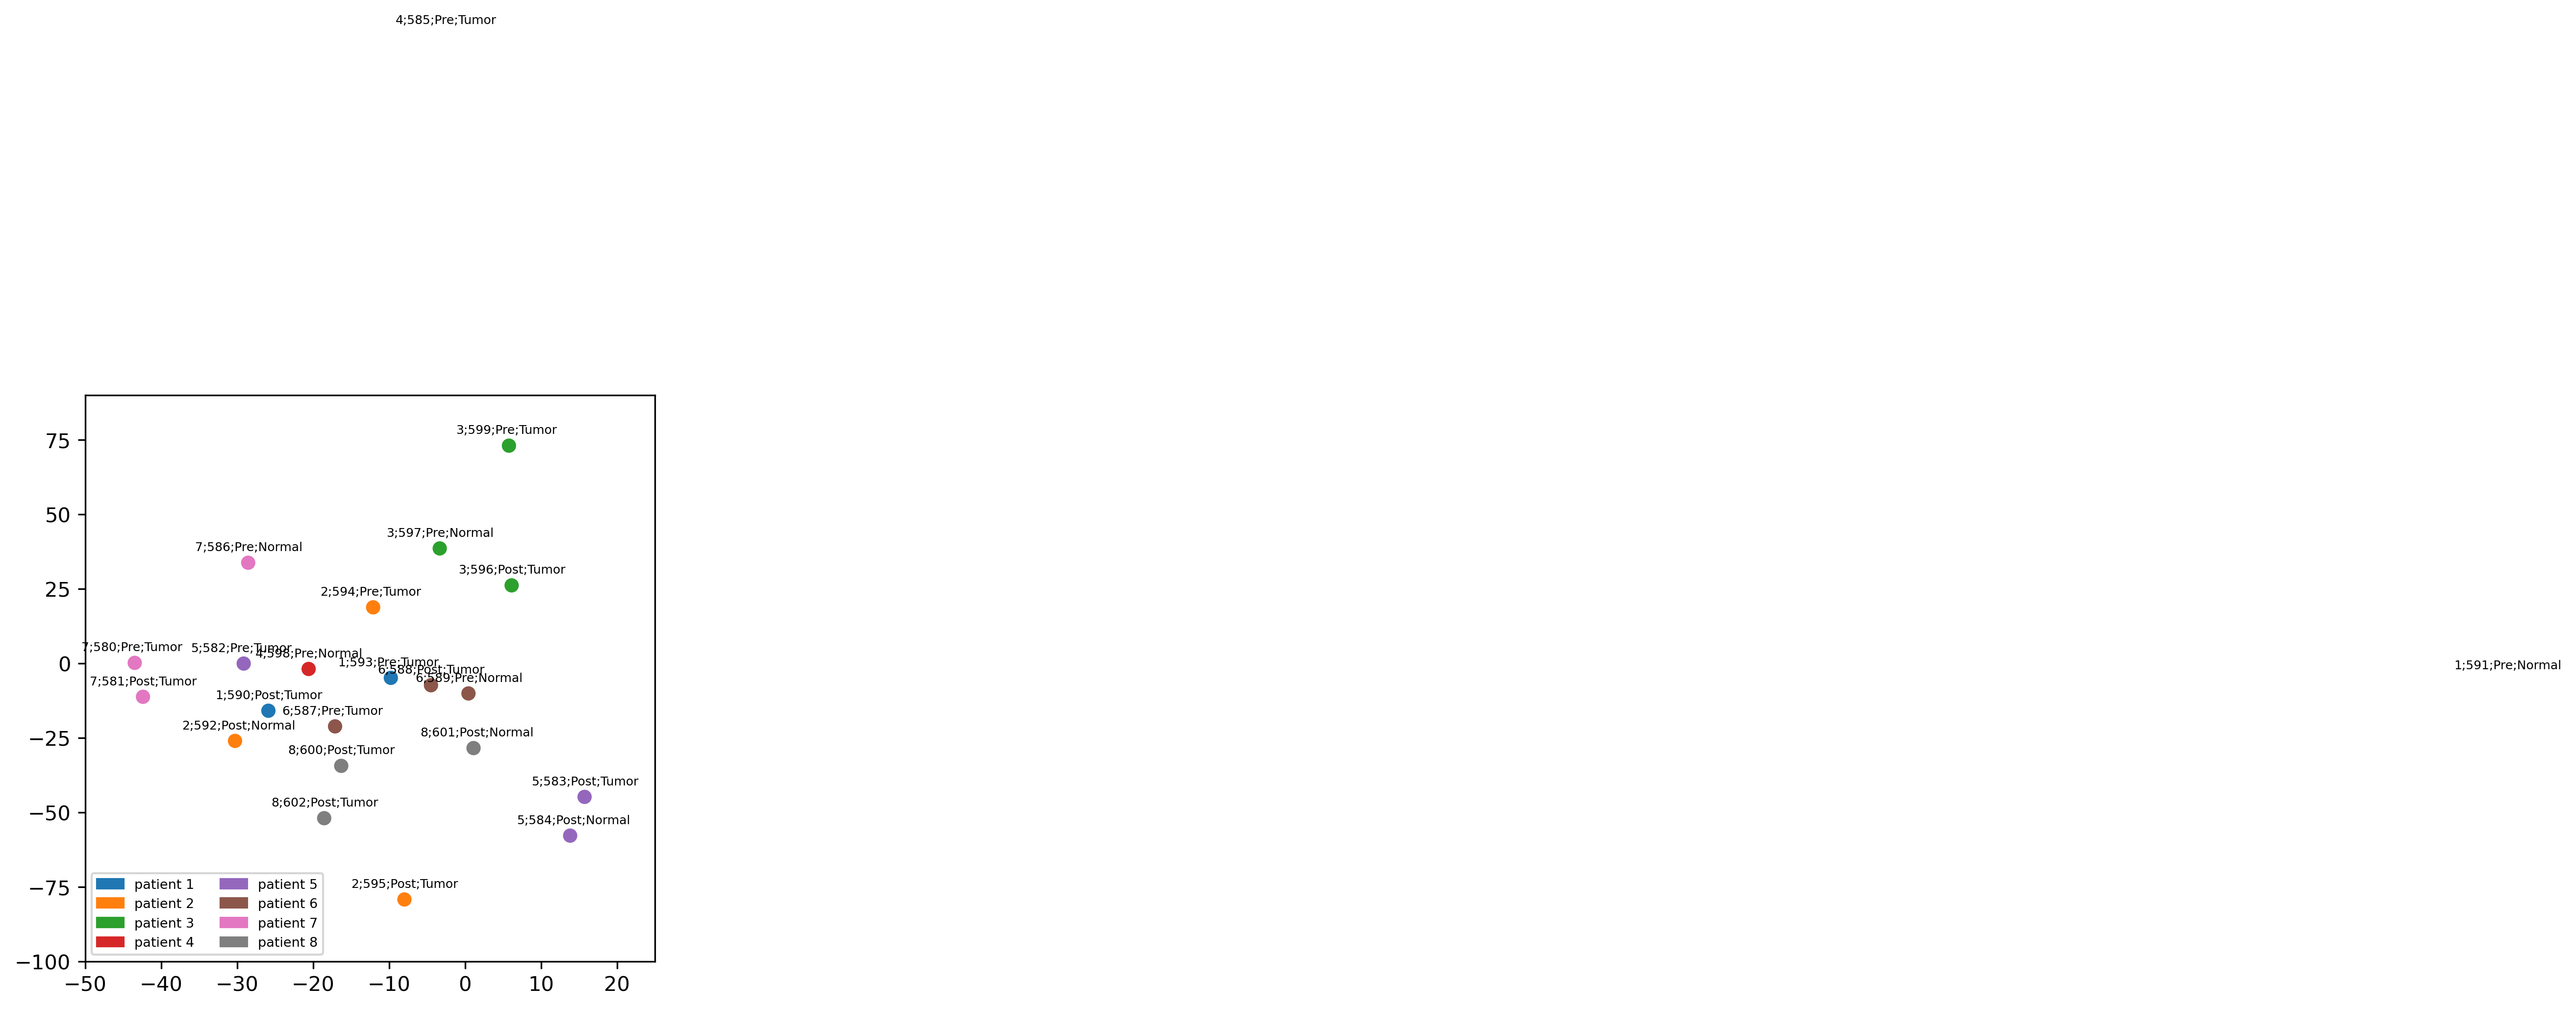

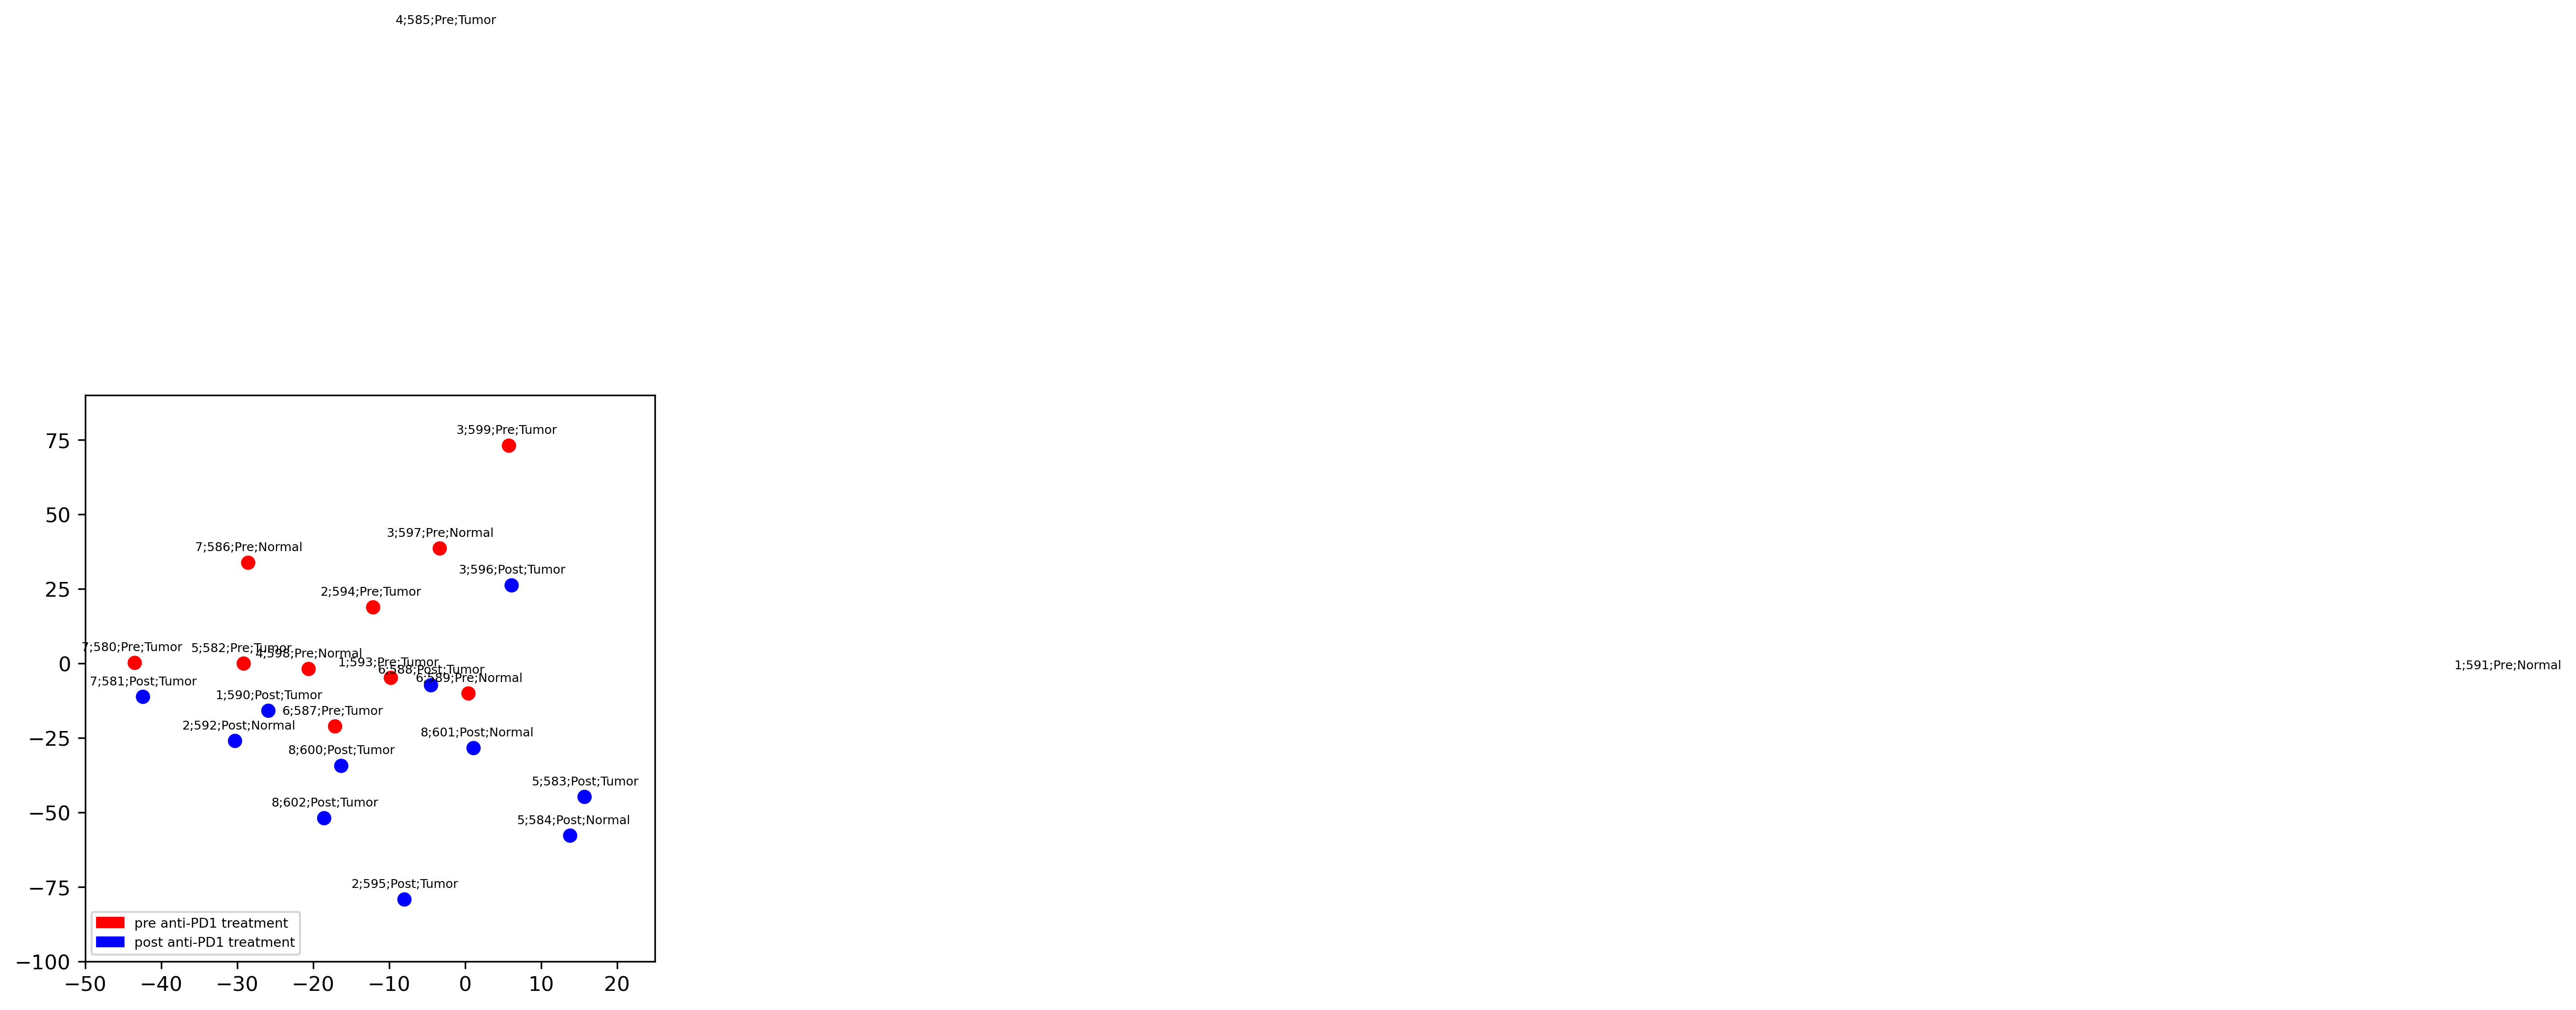

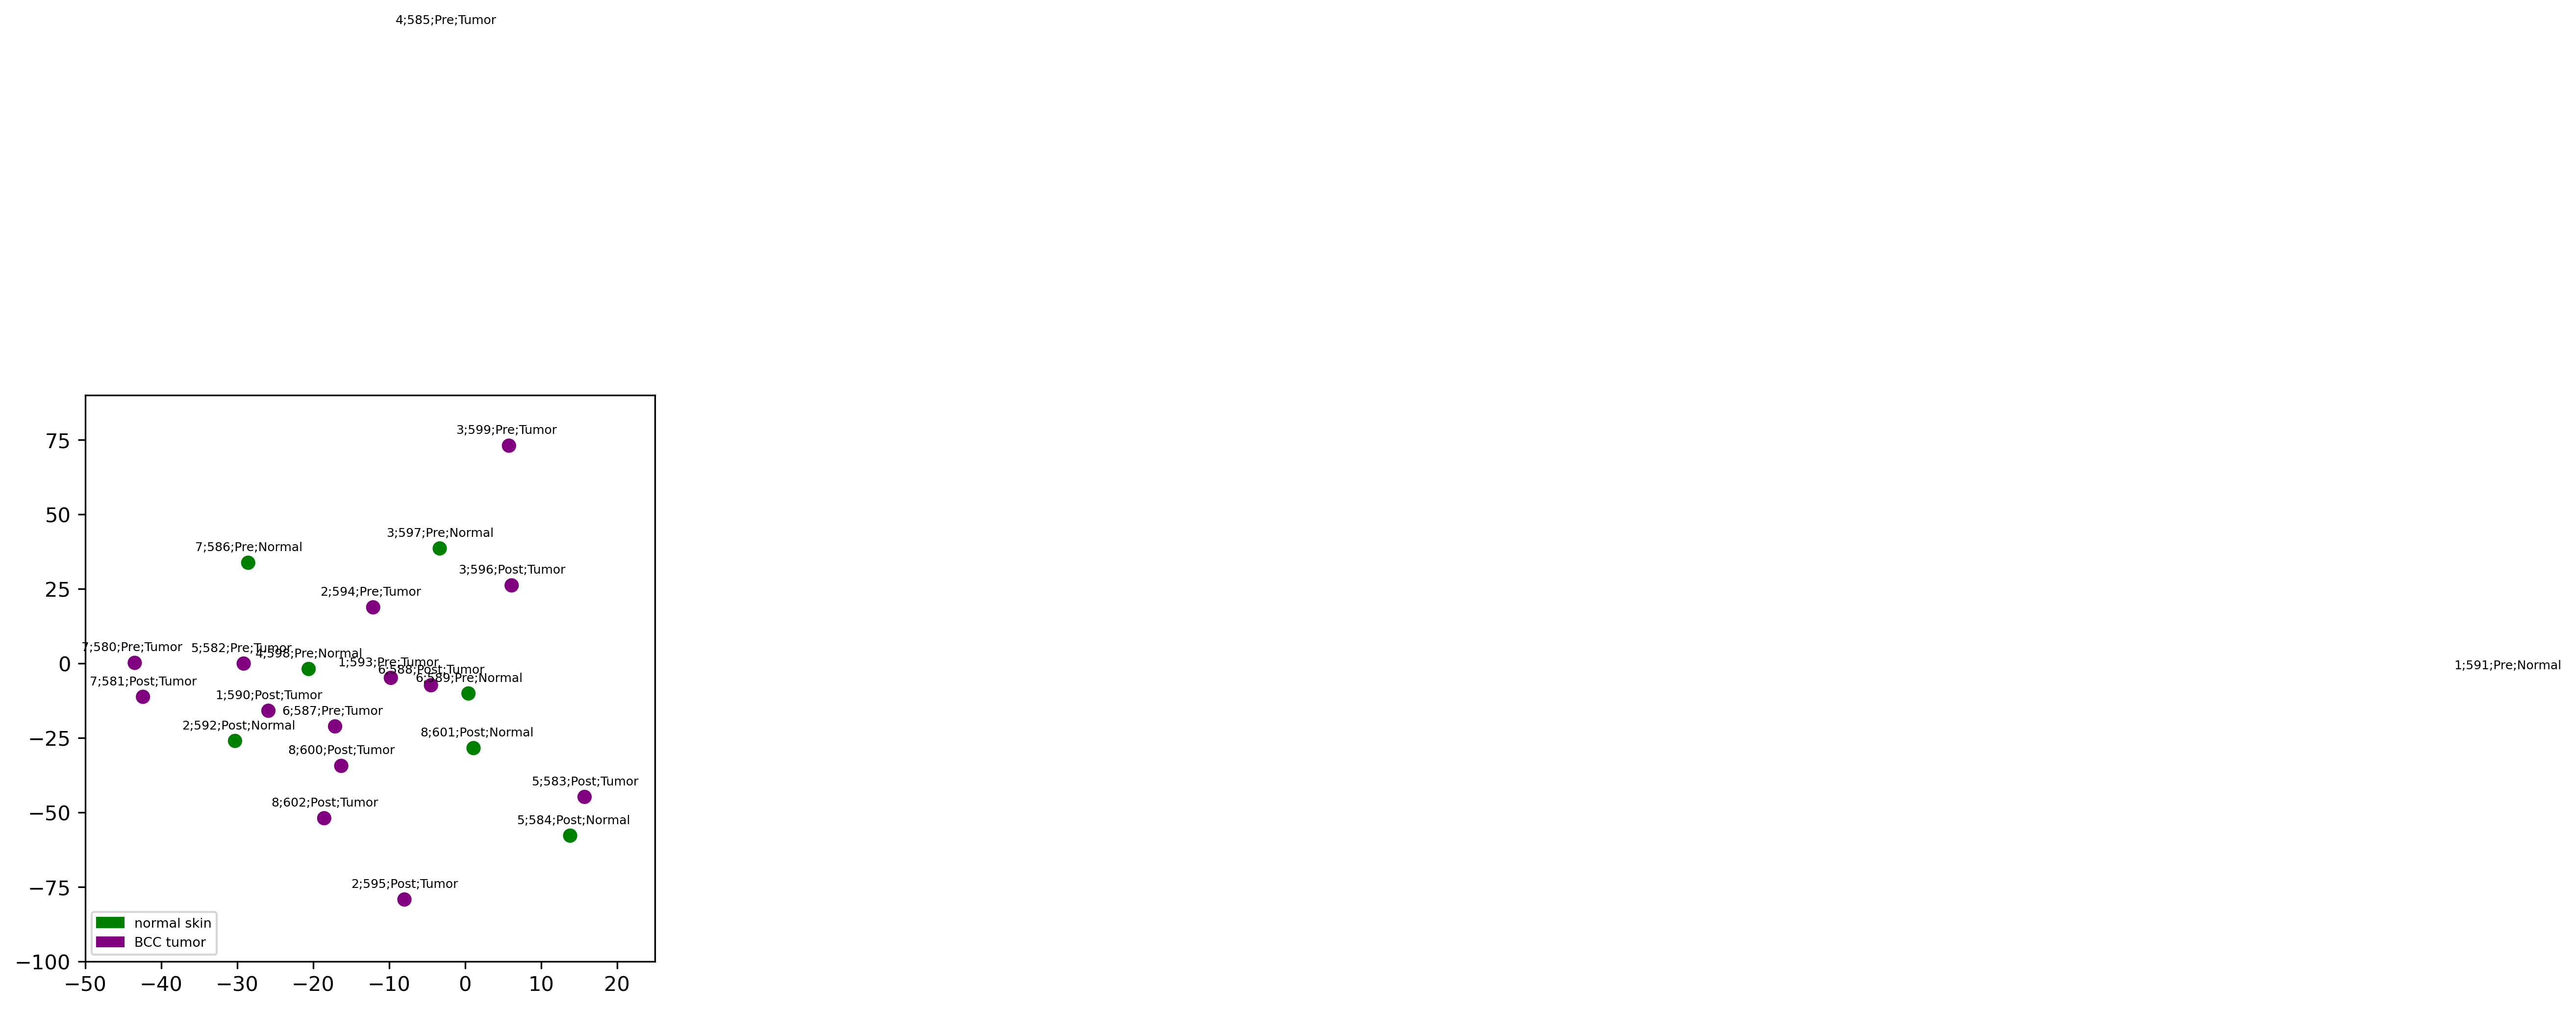

In [56]:
""" plot scatter of PCA1 and PCA2 of all runs """

fontsize=6

labels_stanford = []
for run in profile_stanford["Run"]:
    id, isolate, treatment, tissue = profile_stanford[profile_stanford["Run"] == run].iloc[0]
    id = id[7:]
    treatment = "Pre" if treatment == 0 else "Post"
    tissue = "Normal" if "normal" in tissue else "Tumor"
    labels_stanford.append(f"{isolate};{id};{treatment};{tissue}")

# color by isolate
plt.figure(figsize=(5, 5), dpi=300)
colors = [f"C{i}" for i in range(8)]
plt.scatter(pca_2_stanford[:, 0], pca_2_stanford[:, 1], c=[colors[profile_stanford[profile_stanford["Run"] == run].iloc[0]["Isolate"]-1] for run in profile_stanford["Run"]])
for i in range(len(profile_stanford)):
    plt.text(pca_2_stanford[i, 0]-7, pca_2_stanford[i, 1]+4, labels_stanford[i], fontsize=fontsize)
plt.legend(
    handles=[
        matplotlib.patches.Patch(color=colors[i], label=f"patient {i+1}") for i in range(8)
    ], loc="lower left", ncol=2, fontsize=fontsize+0.5
)
plt.xlim(-50, 25)
plt.ylim(-100, 90)
plt.show()
# color by treatment
plt.figure(figsize=(5, 5), dpi=300)
colors = ["red" if profile_stanford[profile_stanford["Run"] == run].iloc[0]["Treatment"] == 0 else "blue" for run in profile_stanford["Run"]]
plt.scatter(pca_2_stanford[:, 0], pca_2_stanford[:, 1], c=colors)
for i in range(len(profile_stanford)):
    plt.text(pca_2_stanford[i, 0]-7, pca_2_stanford[i, 1]+4, labels_stanford[i], fontsize=fontsize)
plt.legend(
    handles=[
        matplotlib.patches.Patch(color="r", label="pre anti-PD1 treatment"), 
        matplotlib.patches.Patch(color="b", label="post anti-PD1 treatment")
    ], loc="lower left", ncol=1, fontsize=fontsize+0.5
)
plt.xlim(-50, 25)
plt.ylim(-100, 90)
plt.show()
# color by tissue
plt.figure(figsize=(5, 5), dpi=300)
colors = ["green" if "normal" in profile_stanford[profile_stanford["Run"] == run].iloc[0]["Tissue"] else "purple" for run in profile_stanford["Run"]]
plt.scatter(pca_2_stanford[:, 0], pca_2_stanford[:, 1], c=colors)
for i in range(len(profile_stanford)):
    plt.text(pca_2_stanford[i, 0]-7, pca_2_stanford[i, 1]+4, labels_stanford[i], fontsize=fontsize)
plt.legend(
    handles=[
        matplotlib.patches.Patch(color="g", label="normal skin"), 
        matplotlib.patches.Patch(color="purple", label="BCC tumor")
    ], loc="lower left", ncol=1, fontsize=fontsize+0.5
)
plt.xlim(-50, 25)
plt.ylim(-100, 90)
plt.show()

In [ ]:
""" plot correlation heat map of runs for selected pos"""

# TODO: clusting of heat map

runs = profile_stanford["Run"]["Run"].to_list()

# calculate the correlation between each pair of runs
heat_map = pearsonCorrelation(pca_1, pca_1)     # [len(runs), len(runs)]
for i in range(len(heat_map)): heat_map[i, i] = np.nan

# plot the heat map 6*6 
labels = []
for run in runs:
    id, isolate, treatment, tissue = profile_stanford["Run"][profile_stanford["Run"]["Run"] == run].iloc[0]
    labels.append("{}-{}-{}-{}".format(
            id, isolate,
            "Pre" if treatment == 0 else "Post", 
            "Normal" if "normal" in tissue else "Tumor"
        ))
plt.figure(dpi=300, figsize=(20, 18))
sns.heatmap(
    heat_map, annot=True, fmt=".3f", cmap="coolwarm", square=True,
    yticklabels=labels, xticklabels=False
)
plt.title("Pearson Correlation", fontweight='bold')
plt.show()

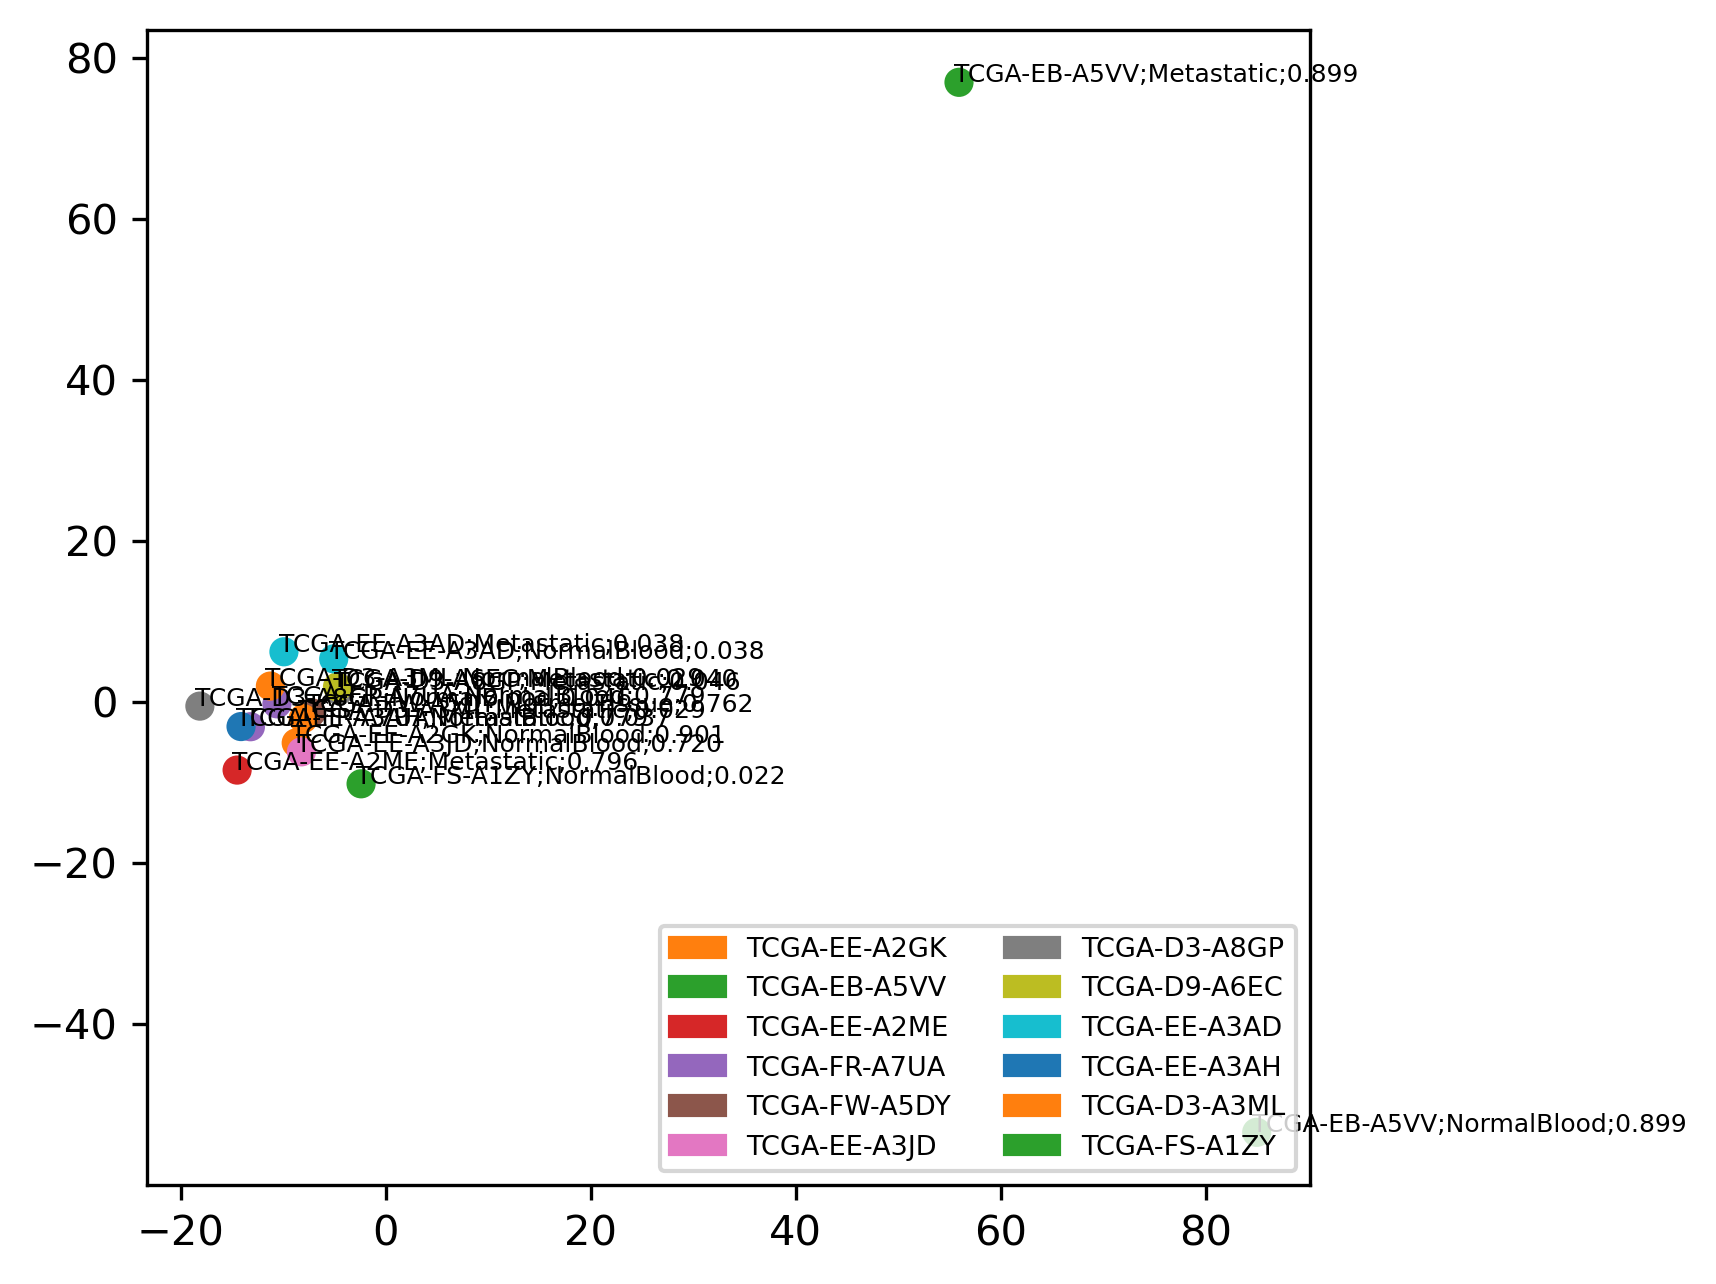

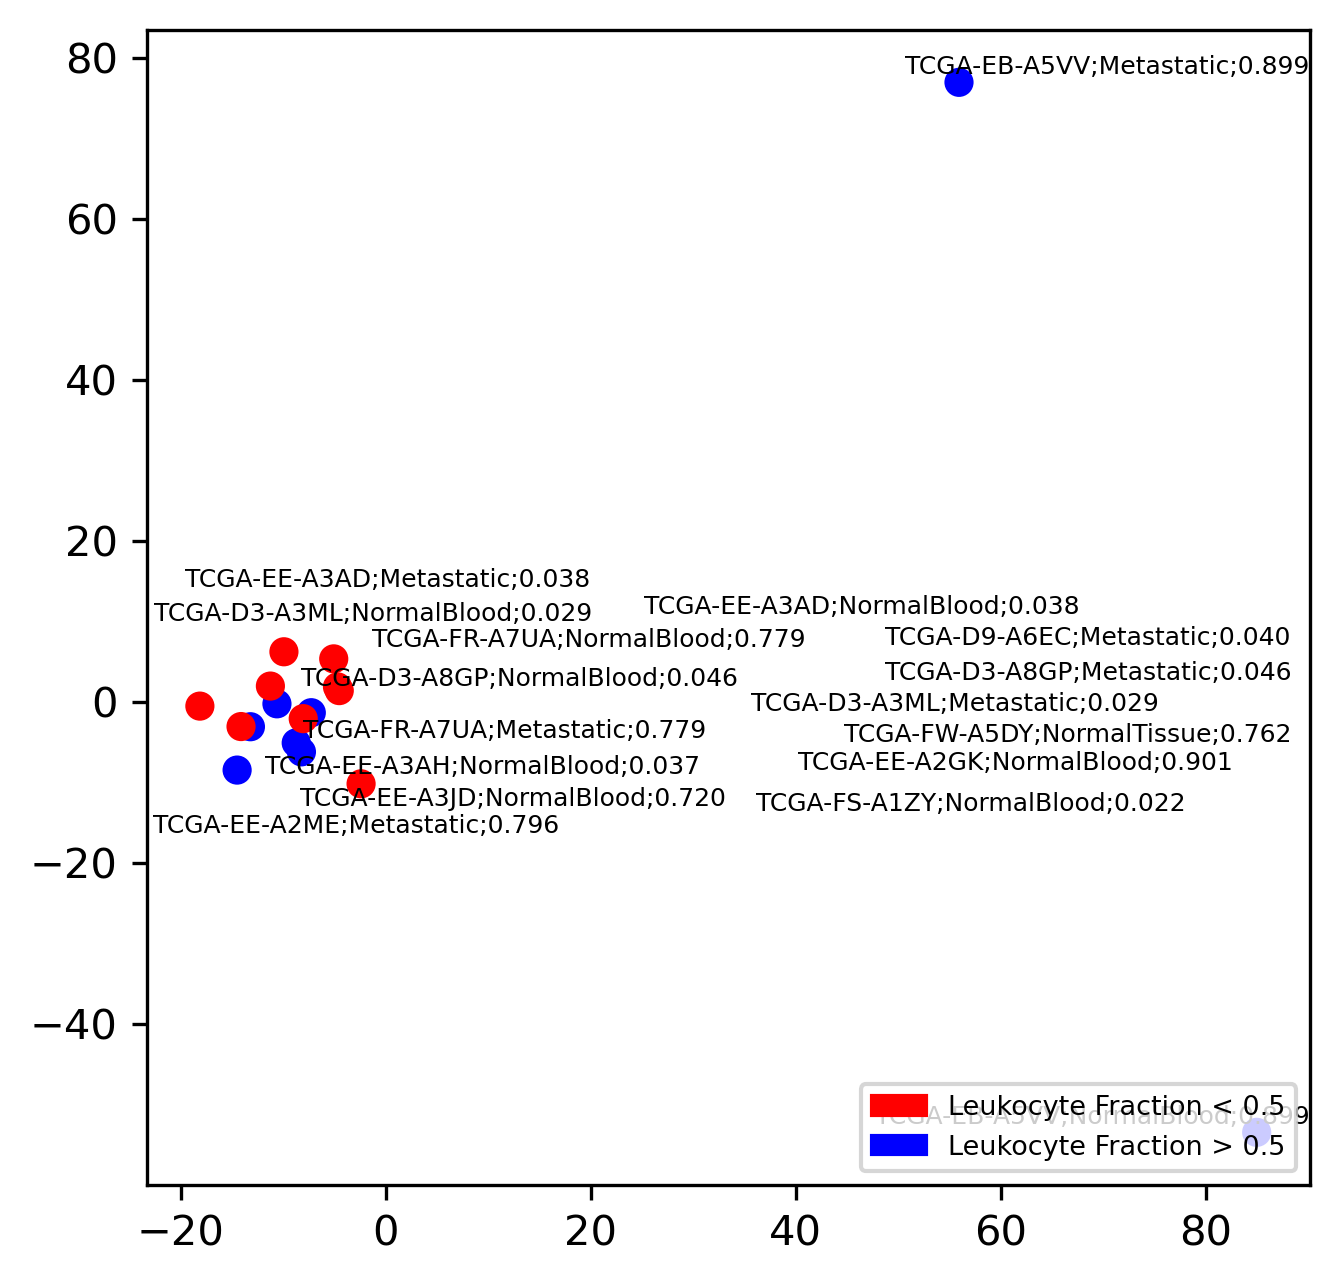

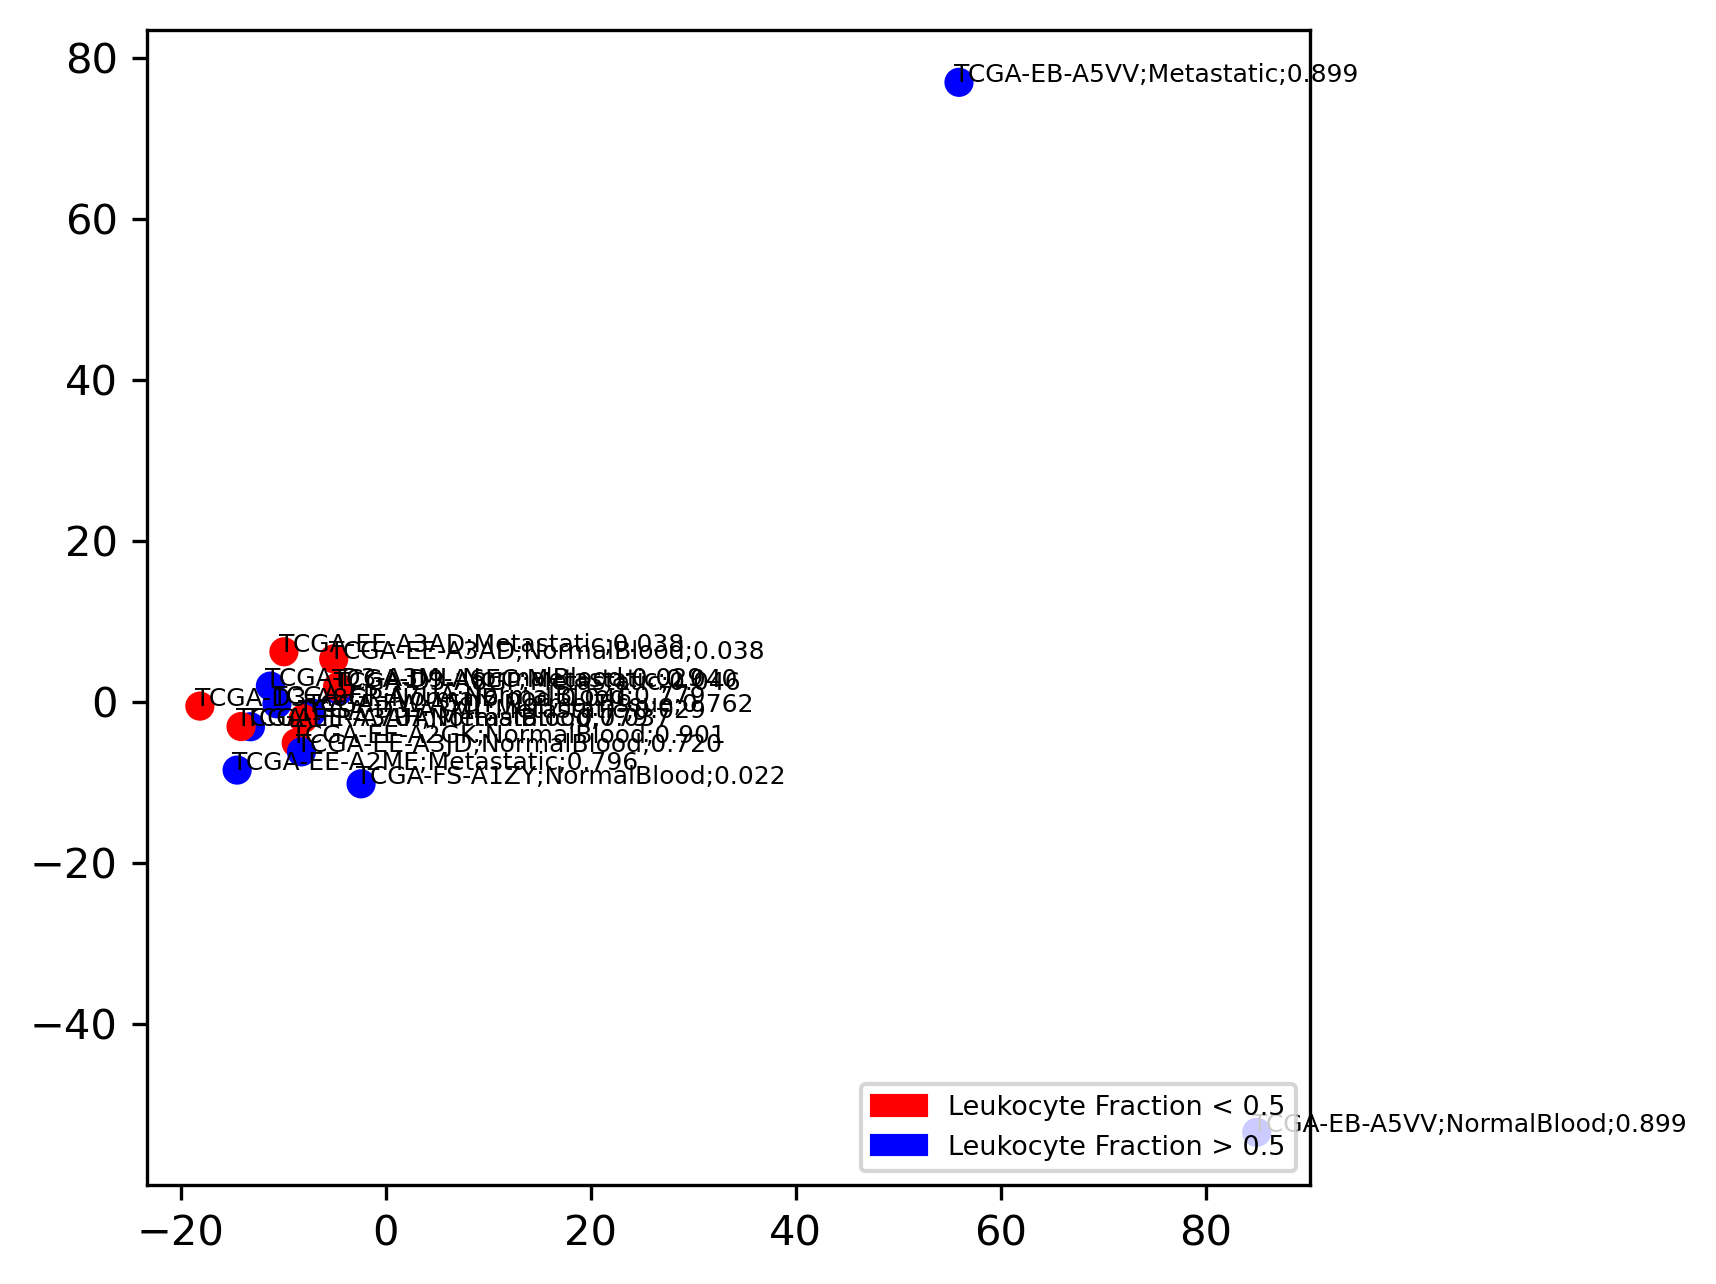

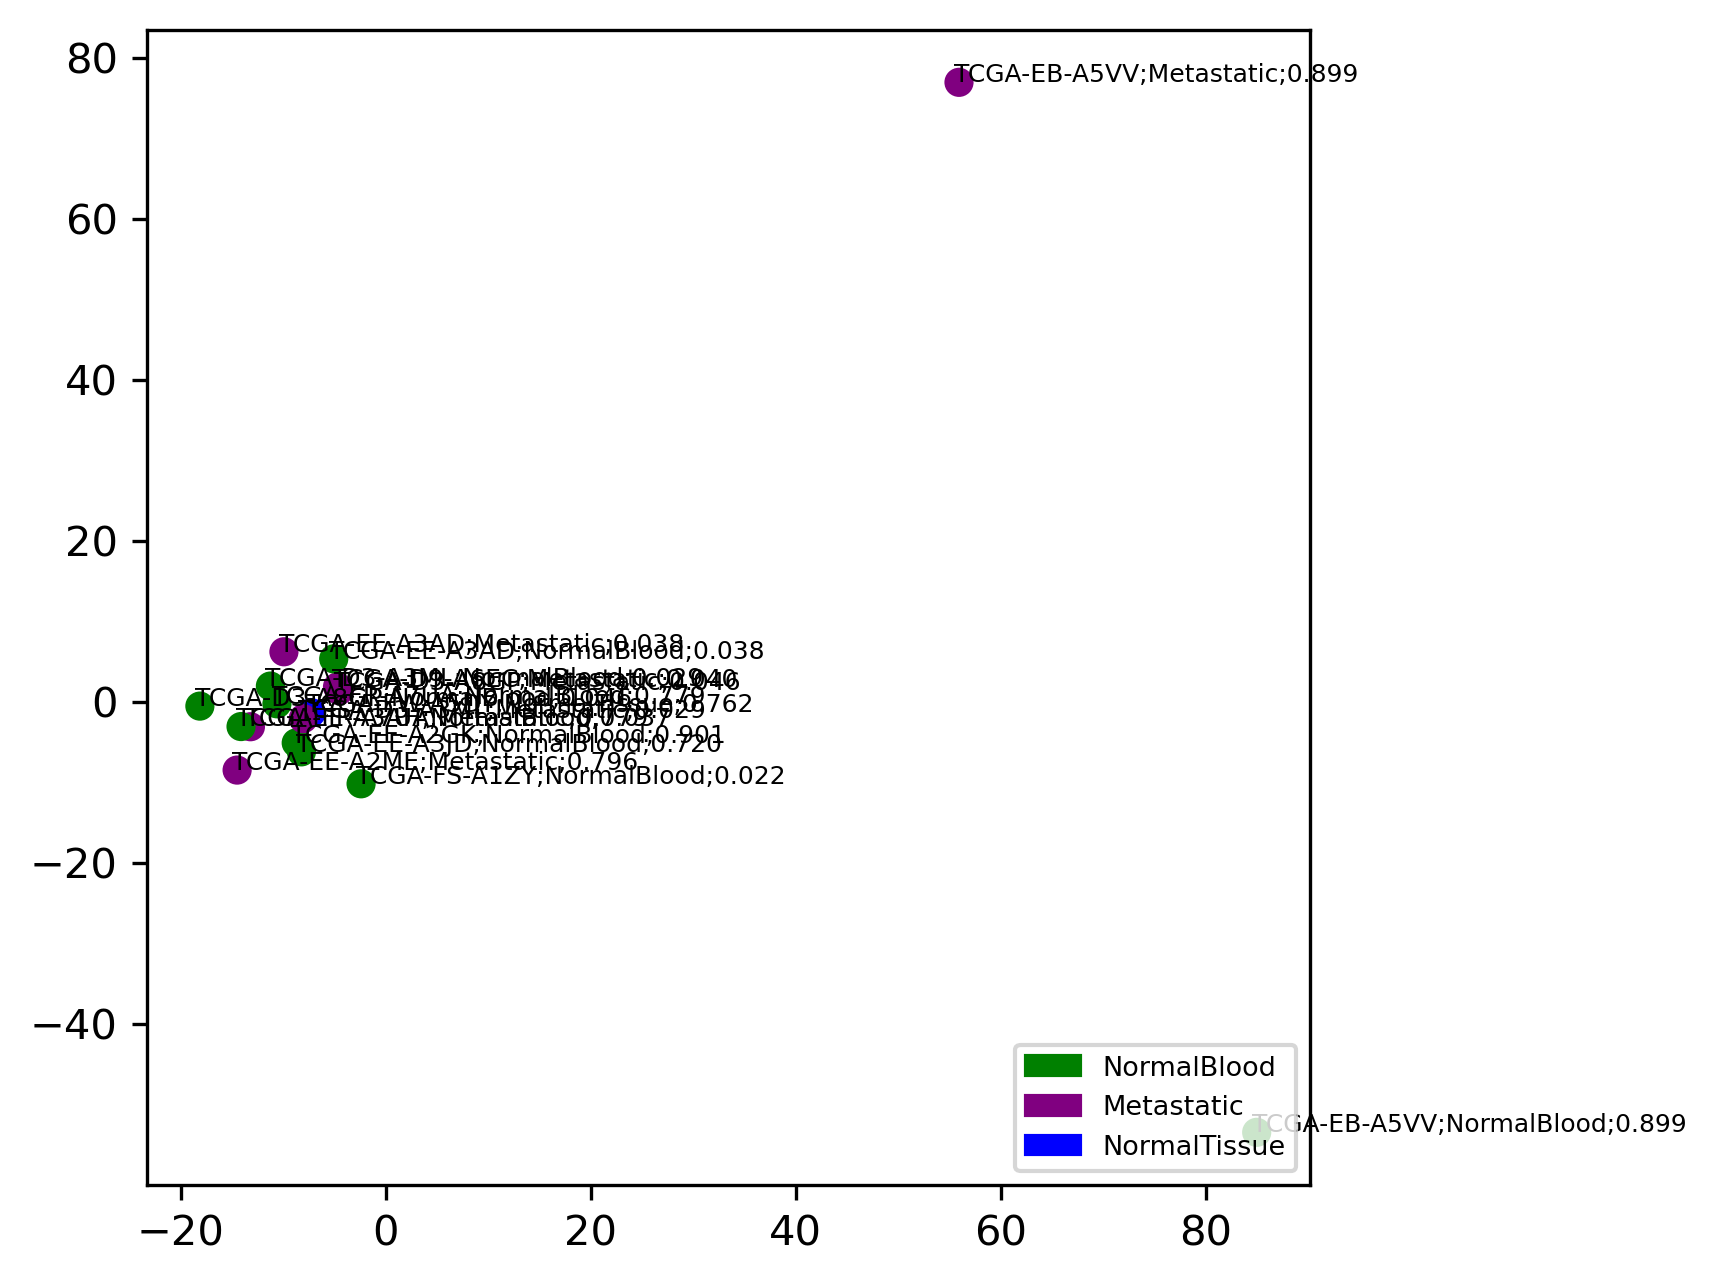

In [9]:
""" plot scatter of PCA1 and PCA2 of all runs """

fontsize=6

# color by patient
colors = ["C1", "C2", "C2", "C3", "C4", "C4", "C5", "C6", "C7", "C7", "C8", "C9", "C9", "C10", "C11", "C11", "C12"]
plt.figure(figsize=(5, 5), dpi=300)
plt.scatter(pca_2_tcgaskcm[:, 0], pca_2_tcgaskcm[:, 1], c=[colors[i] for i in range(len(profile_sample))])
for i in range(len(labels_tcgaskcm)):
    plt.text(pca_2_tcgaskcm[i, 0]-0.5, pca_2_tcgaskcm[i, 1]+0.05, labels_tcgaskcm[i], fontsize=fontsize)
plt.legend(
    handles=[
        matplotlib.patches.Patch(color="C1", label="TCGA-EE-A2GK"), 
        matplotlib.patches.Patch(color="C2", label="TCGA-EB-A5VV"),
        matplotlib.patches.Patch(color="C3", label="TCGA-EE-A2ME"),
        matplotlib.patches.Patch(color="C4", label="TCGA-FR-A7UA"),
        matplotlib.patches.Patch(color="C5", label="TCGA-FW-A5DY"),
        matplotlib.patches.Patch(color="C6", label="TCGA-EE-A3JD"),
        matplotlib.patches.Patch(color="C7", label="TCGA-D3-A8GP"),
        matplotlib.patches.Patch(color="C8", label="TCGA-D9-A6EC"),
        matplotlib.patches.Patch(color="C9", label="TCGA-EE-A3AD"),
        matplotlib.patches.Patch(color="C10", label="TCGA-EE-A3AH"),
        matplotlib.patches.Patch(color="C11", label="TCGA-D3-A3ML"),
        matplotlib.patches.Patch(color="C12", label="TCGA-FS-A1ZY"),
    ], loc="lower right", ncol=2, fontsize=fontsize+0.5
)
plt.show()
# color by ground truth
plt.figure(figsize=(5, 5), dpi=300)
colors = ["red" if profile_sample.loc[run]['Leukocyte Fraction'] == 0 else "blue" for run in profile_sample.index]
plt.scatter(pca_2_tcgaskcm[:, 0], pca_2_tcgaskcm[:, 1], c=colors)
texts = [
    plt.text(pca_2_tcgaskcm[i, 0], pca_2_tcgaskcm[i, 1], labels_tcgaskcm[i], fontsize=fontsize) 
    for i in range(len(labels_tcgaskcm))
]
adjustText.adjust_text(texts)
plt.legend(
    handles=[
        matplotlib.patches.Patch(color="r", label="Leukocyte Fraction < 0.5"), 
        matplotlib.patches.Patch(color="b", label="Leukocyte Fraction > 0.5")
    ], loc="lower right", ncol=1, fontsize=fontsize+0.5
)
plt.show()
# color by prediction
plt.figure(figsize=(5, 5), dpi=300)
colors = ["red" if y_tcgaskcm[i] == 0 else "blue" for i in range(len(y_tcgaskcm))]
plt.scatter(pca_2_tcgaskcm[:, 0], pca_2_tcgaskcm[:, 1], c=colors)
for i in range(len(labels_tcgaskcm)):
    plt.text(pca_2_tcgaskcm[i, 0]-0.5, pca_2_tcgaskcm[i, 1]+0.05, labels_tcgaskcm[i], fontsize=fontsize)
plt.legend(
    handles=[
        matplotlib.patches.Patch(color="r", label="Leukocyte Fraction < 0.5"), 
        matplotlib.patches.Patch(color="b", label="Leukocyte Fraction > 0.5")
    ], loc="lower right", ncol=1, fontsize=fontsize+0.5
)
plt.show()
# color by tissue
plt.figure(figsize=(5, 5), dpi=300)
colors = []
for run in profile_sample.index:
    if profile_sample.loc[run]['Sample Type'].startswith("Blood"): colors.append("green")
    elif profile_sample.loc[run]['Sample Type'].startswith("Metastatic"): colors.append("purple")
    else: colors.append("blue")
plt.scatter(pca_2_tcgaskcm[:, 0], pca_2_tcgaskcm[:, 1], c=colors)
for i in range(len(labels_tcgaskcm)):
    plt.text(pca_2_tcgaskcm[i, 0]-0.5, pca_2_tcgaskcm[i, 1]+0.05, labels_tcgaskcm[i], fontsize=fontsize)
plt.legend(
    handles=[
        matplotlib.patches.Patch(color="green", label="NormalBlood"), 
        matplotlib.patches.Patch(color="purple", label="Metastatic"),
        matplotlib.patches.Patch(color="blue", label="NormalTissue"),
    ], loc="lower right", ncol=1, fontsize=fontsize+0.5
)
plt.show()

In [ ]:
""" Plot Hexbin N * N+1"""

"""
gridsize = 80
vmin, vmax = 4, 64
fontsize = 18

fig, axs = plt.subplots(
    len(runs), len(runs)+1, figsize=(35, 30), 
    sharex=True, sharey=True
)
# plot
for i in range(len(runs)):
    # plot umpa of sample i before filter in diagonal
    axs[i, i].hexbin(
        umap[runs[i]][:, 0], umap[runs[i]][:, 1], 
        cmap="Reds", gridsize=gridsize, vmin=vmin, vmax=vmax,
    )
    # plot umap of (i, :) and (:, i) after filter by distance (i, j)
    for j in range(i+1, len(runs)):
        # umap of (i, :)
        axs[i, j].hexbin(
            umap[runs[i]][:, 0], umap[runs[i]][:, 1], 
            cmap="Reds", gridsize=gridsize, vmin=vmin, vmax=vmax/2,
        )
        # umap of (:, i)
        axs[j, i].hexbin(
            umap[runs[j]][:, 0], umap[runs[j]][:, 1], 
            cmap="Reds", gridsize=gridsize, vmin=vmin, vmax=vmax/2,
        )
    # plot umap of (i, len(runs)) of combine all filter
    axs[i, len(runs)].hexbin(
        umap[runs[i]][:, 0], 
        umap[runs[i]][:, 1], 
        cmap="Reds", gridsize=gridsize, vmin=vmin, vmax=vmax/2,
    )
# set up axis and label
for i in range(len(runs)):
    id, isolate, treatment, tissue = profile[profile["Run"] == runs[i]].iloc[0]
    treatment = "Pre" if treatment == 0 else "Post"
    tissue = "Normal" if "normal" in tissue else "Tumor"
    info = f"{id} - {isolate} - {treatment} - {tissue}"
    axs[0,  i].set_xlabel(info, fontsize=fontsize, fontweight='bold')
    axs[0,  i].xaxis.set_label_position("top")
    axs[0, len(runs)].set_xlabel("All Selected Reads", fontsize=fontsize, fontweight='bold')
    axs[0, len(runs)].xaxis.set_label_position("top")
    axs[i, -1].set_ylabel(info, fontsize=fontsize, fontweight='bold')
    axs[i, -1].yaxis.set_label_position("right")
    for j in range(len(runs)+1):
        axs[i, j].set_aspect("equal")
        axs[i, j].set_xlim(-22, 22)
        axs[i, j].set_ylim(-22, 22)
fig.supxlabel("UMAP1", fontsize=fontsize, fontweight='bold', y=0.004)
fig.supylabel("UMAP2", fontsize=fontsize, fontweight='bold', x=0.008)
fig.tight_layout()
fig.savefig("temp.png", dpi=500)
fig.show()
"""

""" Plot Hexbin of all samples """

"""
gridsize = 80
vmin, vmax = 4, 64
fontsize = 18

# hexbin, split by isolate
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
umap_isolates = [None, None]
for i in range(len(runs)):
    axs_index = 0 if profile[profile["Run"] == runs[i]]["Isolate"].values[0] == 3 else 1
    if umap_isolates[axs_index] is None:
        umap_isolates[axs_index] = umap[runs[i]]
    else:
        umap_isolates[axs_index] = np.concatenate(
            [umap_isolates[axs_index], umap[runs[i]]]
        )
for axs_index in range(2):
    axs[axs_index].hexbin(
        umap_isolates[axs_index][:, 0], umap_isolates[axs_index][:, 1], 
        cmap="Reds", gridsize=gridsize, vmin=vmin, vmax=vmax,
    )
    axs[axs_index].set_xlim(-22, 22)
    axs[axs_index].set_ylim(-22, 22)
    axs[axs_index].set_title(
        "su003" if axs_index == 0 else "su007", 
        fontweight='bold', fontsize=fontsize
    )
fig.tight_layout()
fig.show()

# hexbin, split by treatment
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
umap_treatments = [None, None]
for i in range(len(runs)):
    axs_index = profile[profile["Run"] == runs[i]]["Treatment"].values[0]
    if umap_treatments[axs_index] is None:
        umap_treatments[axs_index] = umap[runs[i]]
    else:
        umap_treatments[axs_index] = np.concatenate(
            [umap_treatments[axs_index], umap[runs[i]]]
        )
for axs_index in range(2):
    axs[axs_index].hexbin(
        umap_treatments[axs_index][:, 0], umap_treatments[axs_index][:, 1], 
        cmap="Reds", gridsize=gridsize,
        vmin = vmin if axs_index == 0 else (vmin/2),
        vmax = vmax if axs_index == 0 else (vmax/2)
    )
    axs[axs_index].set_xlim(-22, 22)
    axs[axs_index].set_ylim(-22, 22)
    axs[axs_index].set_title(
        "Pre" if axs_index == 0 else "Post", 
        fontweight='bold', fontsize=fontsize
    )
fig.tight_layout()
fig.show()
"""